In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
from matplotlib.ticker import StrMethodFormatter

In [2]:
data_dir = './LAB DATA/'
save_dir = './latex/'

In [3]:
Power_H = np.arange(-20,1) # Power recorded on the hittite power supply
Power_S = np.array([-20.8, -19.8, -18.8, -17.7, -16.7, -15.7, -14.6, -13.55, -12.6,\
                   -11.6, -10.6, -9.6, -8.6, -7.6, -6.7, -5.7, -4.8, -4, -3, -2, -1]) # Power as measured on the power sensor
Power_amp = np.array([-6.7, -5.7, -4.6, -3.7, -2.7, -1.6, -0.6, 0.4, 1.4, 2.4, 3.34, 4.3,\
                     5.2, 6, 6.7, 7.2, 7.4, 7.5, 7.6, 7.7, 7.7])

In [4]:
Y = Power_amp[:7]
A = np.vstack([Power_S[:7], np.ones(7)]).T
X = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, Y))
m = X[0]
b = X[1]
print("m = {0:1.3f}, b = {1:1.3f}".format(m, b))

m = 0.982, b = 13.759


In [5]:
x = np.r_[-21:0:100j]
y = m * x + b

In [6]:
# def nonlinearity(theta, x):
#     b, m, gamma = theta
#     return b + m * x + gamma * x**2

def sat_curve(theta, x):
    L, k, x0, delta = theta
    return L/(1 + np.exp(-k * (x - x0))) - delta

def chisq(theta, x, y, yerr):
    return 0.5 * np.sum((y - sat_curve(theta, x))**2/yerr**2)

In [7]:
# Let's try a curve fit to the saturation curve
result = opt.minimize(chisq, [7.7, 0.510, -10.09, -14.01], args=(Power_S, Power_amp, np.ones_like(Power_amp)),\
                      method='Powell')
L, k, x0, delta = result['x']
print("L = {0:1.4f}, k = {1:1.4f}, x0 = {2:1.4f}, delta = {3:1.4f}".format(L, k, x0, delta))

L = -18.4262, k = -0.2416, x0 = -14.4626, delta = -8.7806


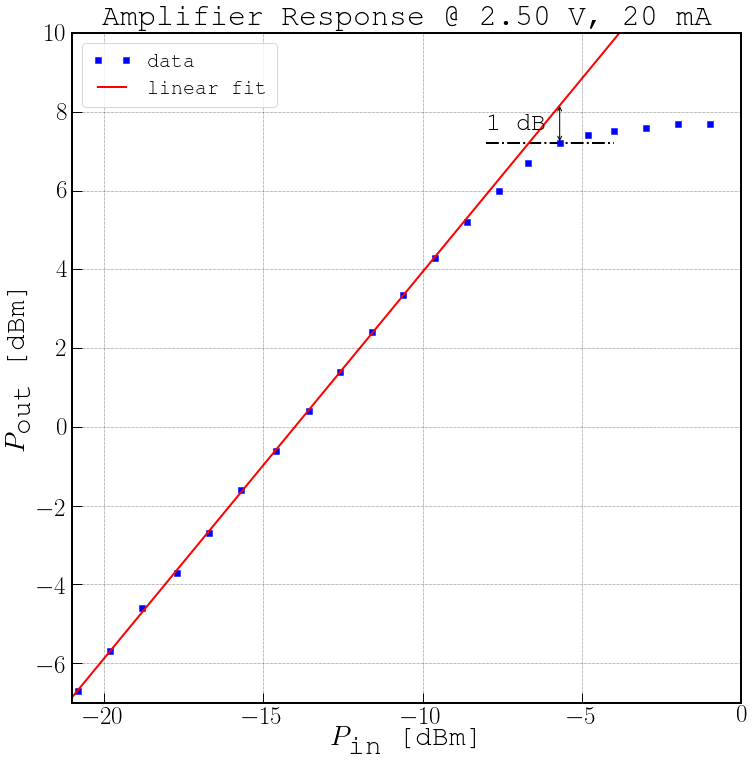

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(Power_S, Power_amp, 'bs', label='data')
ax.plot(x, y, 'r-', label='linear fit')
# ax.plot(x, y-1, 'g')
ax.hlines(7.2, -8, -4, 'k', 'dashdot')
# ax.vlines(-5.7, -7, 10, 'k', 'dashed')
# ax.plot(x, sat_curve((L, k, x0, delta), x), 'g')
ax.set_xlabel(r'$P_{\texttt{in}}$ [dBm]')
ax.set_ylabel(r'$P_{\texttt{out}}$ [dBm]')
ax.grid(which='both')
ax.legend(loc='best')
ax.axis([-21, 0, -7, 10])
ax.text(-7.0, 7.7, "1 dB", ha='center', va='center', size=25)
ax.annotate("",
    xy=(-5.7, 8.2), xycoords='data',
    xytext=(-5.7, 7.2), textcoords='data',
    arrowprops=dict(arrowstyle="<->",
    connectionstyle="arc3"),
)
ax.set_title(r'Amplifier Response @ 2.50 V, 20 mA');
plt.savefig(save_dir + 'compression_point.pdf')

In [9]:
# Need to find the P_1dB point of the amplifier
diff = (Power_S * m + b) - Power_amp
print(Power_amp[np.where(np.abs(diff) >= 0.9 )[0]])
print(Power_S[np.where(np.abs(diff) >= 0.9 )[0]])

[ 7.2  7.4  7.5  7.6  7.7  7.7]
[-5.7 -4.8 -4.  -3.  -2.  -1. ]


In [10]:
attenuation = 10
freq_out, P_out = np.loadtxt(data_dir + 'O.csv', delimiter=',', unpack=True, skiprows=16, usecols=[0,1])
freq_0dB, P_0dB = np.loadtxt(data_dir + '0D.csv', delimiter=',', unpack=True, skiprows=16, usecols=[0,1])
freq_20dB, P_20dB = np.loadtxt(data_dir + '20D.csv', delimiter=',', unpack=True, skiprows=16, usecols=[0,1])

P_0dB += attenuation
P_20dB += attenuation
freq_out /= 1e9
freq_0dB /= 1e9
freq_20dB /= 1e9

In [11]:
def autocorr(x):
    res = np.correlate(x, x, mode='full')
    return res[res.size//2:] # We want an integer index

In [12]:
P_corr = autocorr(P_out) #Autocorrelated power

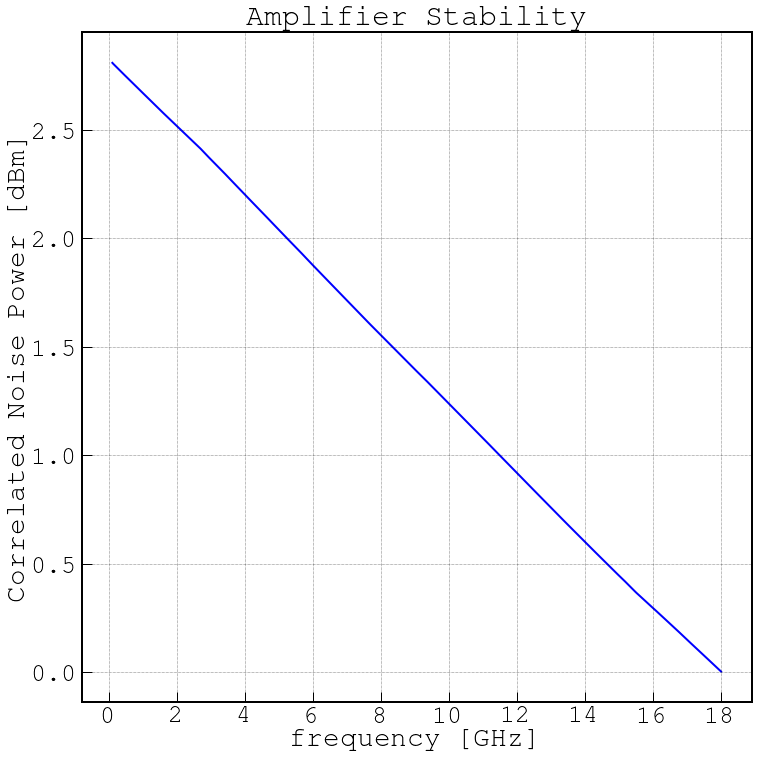

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(freq_out, P_corr/1e6, 'b')
ax.set_xlabel(r'frequency [GHz]')
ax.set_ylabel(r'Correlated Noise Power [dBm]')
ax.grid(which='both')
# ax.axis([0, 18, -80, 0])
ax.set_xticks(np.arange(0, 19, 2))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:2.0f}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:2.1f}"))
ax.set_title(r'Amplifier Stability');
# plt.savefig(save_dir + 'compression_point.pdf')

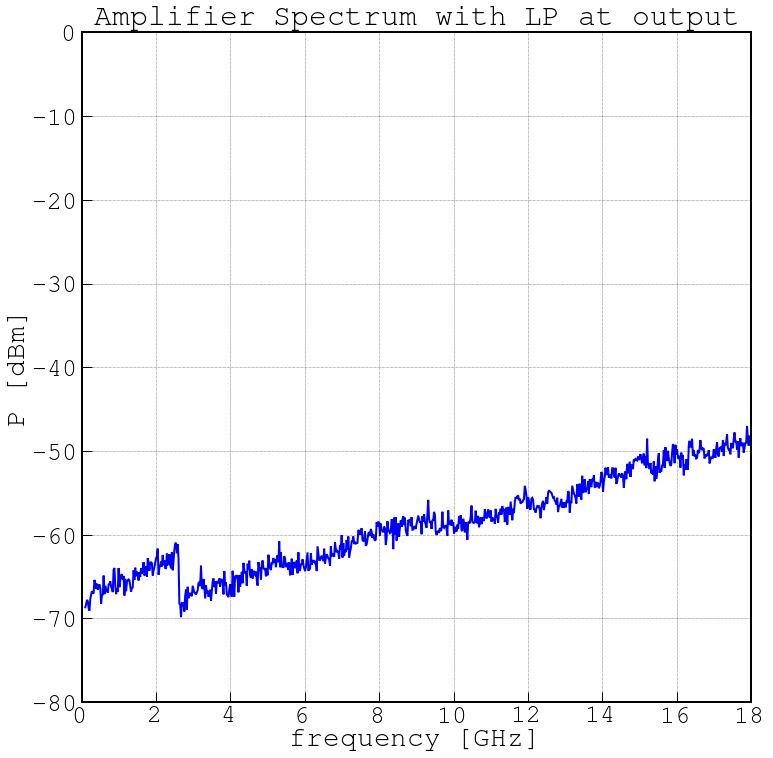

In [14]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(freq_out, P_out, 'b')
ax.set_xlabel(r'frequency [GHz]')
ax.set_ylabel(r'P [dBm]')
ax.grid(which='both')
ax.axis([0, 18, -80, 0])
ax.set_xticks(np.arange(0, 19, 2))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:2.0f}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:2.0f}"))
ax.set_title(r'Amplifier Spectrum with LP at output');
plt.savefig(save_dir + 'amplifier_stability.pdf')

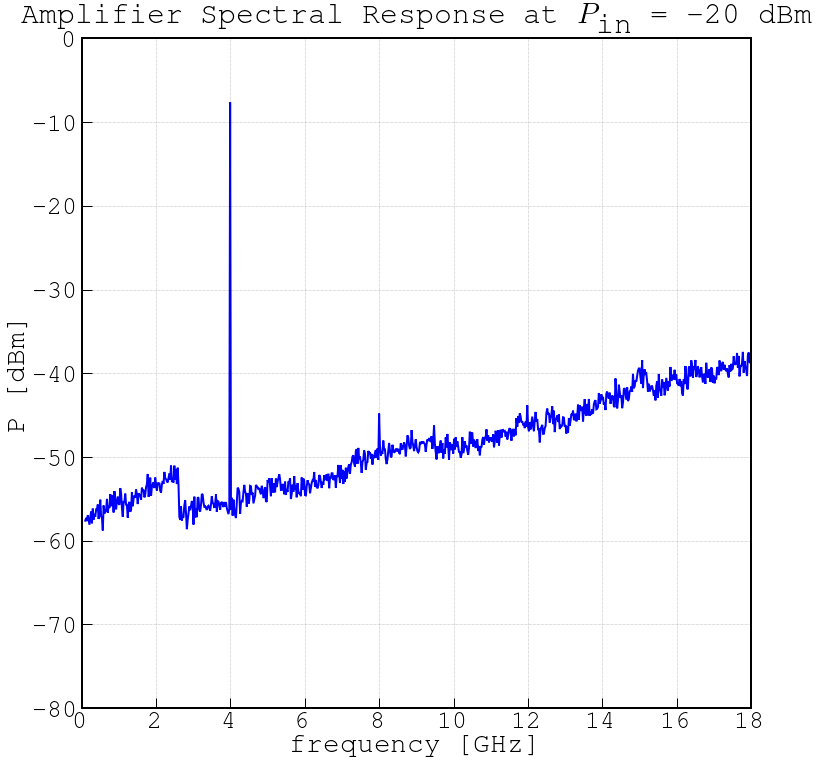

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(freq_20dB, P_20dB, 'b')
ax.set_xlabel(r'frequency [GHz]')
ax.set_ylabel(r'P [dBm]')
ax.grid(which='both', alpha=0.5) 
ax.axis([0, 18, -80, 0])
ax.set_xticks(np.arange(0, 19, 2))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:2.0f}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:2.0f}"))
ax.set_title(r'Amplifier Spectral Response at $P_{\texttt{in}}$ = -20 dBm');
plt.savefig(save_dir + 'Power_20dB.pdf')

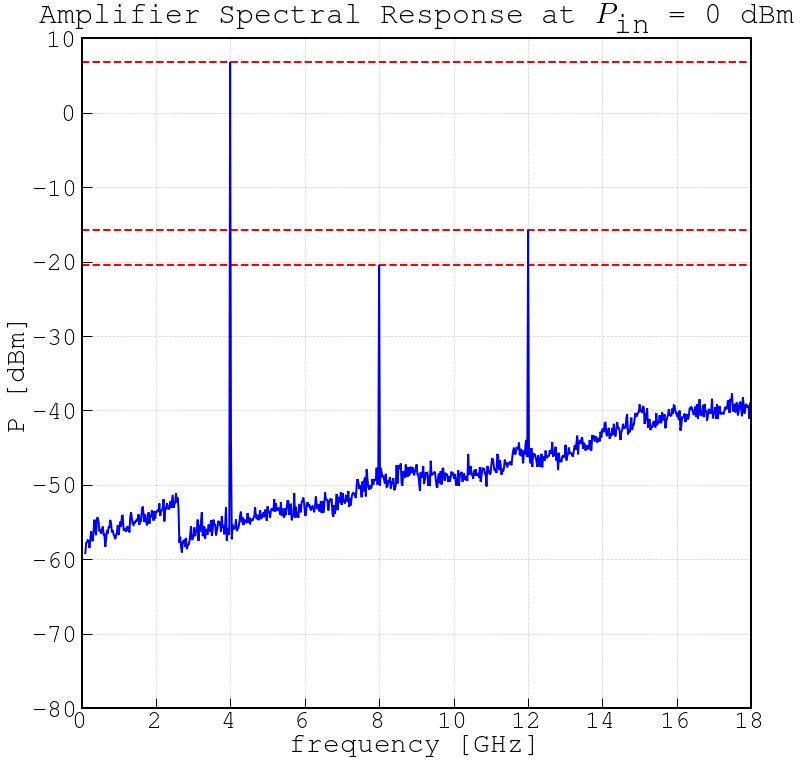

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(freq_0dB, P_0dB, 'b')
ax.set_xlabel(r'frequency [GHz]')
ax.set_ylabel(r'P [dBm]')
ax.grid(which='both',alpha=0.5)
ax.axis([0, 18, -80, 10])
ax.set_xticks(np.arange(0, 19, 2))
ax.hlines(-15.77, 0, 18, 'r', 'dashed')
ax.hlines(-20.5, 0, 18, 'r', 'dashed')
ax.hlines(6.77, 0, 18, 'r', 'dashed')
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:2.0f}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:2.0f}"))
ax.set_title(r'Amplifier Spectral Response at $P_{\texttt{in}}$ = 0 dBm');
plt.savefig(save_dir + 'Power_0dB.pdf')

In [19]:
np.max(P_0dB)

6.7694456010000001

In [17]:
P_0dB.size

801

In [18]:
np.max(P_0dB[:260])

6.7694456010000001

In [19]:
np.max(P_0dB[260:530])

-20.496810539999998

In [20]:
np.max(P_0dB[530:])

-15.76746099